In [2]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS, TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import KFold
from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.cross_validation import cross_val_score
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from nlp_processing import LemmaTokenizer, reduce_nlp_data, combine_scale
%config InlineBackend.figure_format = 'svg'

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [13]:
# Helper function for printing confusion matrices (see: https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823)
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap = 'cividis')
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

def scale_nlp_xtrain(X_train, vectorizer, reducer, standard_scaler, n_components):
    text_data = X_train['text'].values
    numeric_data = pd.concat((X_train.iloc[:, 0], X_train.iloc[:, 2:]), axis = 1)
    column_names = ([f'Topic {i}' for i in range(n_components)] + [X_train.columns[0]] + [col for col in X_train.columns[2:]])
    reducer, reduced_data = reduce_nlp_data(vectorizer, text_data, n_components, reducer)
    ssX, X_train_scaled = combine_scale(reduced_data, numeric_data, standard_scaler)
    return X_train_scaled, column_names, ssX, vectorizer, reducer

def transform_testdata(X_test, vectorizer, reducer, standard_scaler):
    test_text_data = X_test['text'].values
    test_numeric_data = pd.concat((X_test.iloc[:, 0], X_test.iloc[:, 2:]), axis = 1)
    vect_data = vectorizer.transform(test_text_data)
    red_data = reducer.transform(vect_data)
    combined_data = np.hstack((red_data, test_numeric_data))
    X_test_scaled = standard_scaler.transform(combined_data)
    return X_test_scaled
    
# Function used to plot the learning curve, roc curve, and confusing matrix for the given model
def plot_model_nlp(model, nlp_tuple, X, y, metric):
    
    vec = nlp_tuple[0]
    red = nlp_tuple[1]
    standard_scaler = nlp_tuple[2]
    n_components = nlp_tuple[3]
    
    train_sizes = [0.1, 0.3, 0.5, 0.7, 0.9]
    train_err = []
    test_err = []
    m = []
    
    _, X_test, _, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
    
    for train_split in train_sizes:
        
        X_train, _, y_train, _ = train_test_split(X, y, train_size = train_split, random_state = 42)
        X_train_scaled, column_names, ssX, vectorizer, reducer = scale_nlp_xtrain(X_train, vec, red, standard_scaler, n_components)
        model.fit(X_train_scaled, y_train)
        y_predict = model.predict(X_train_scaled)
        metric_train = np.round(np.mean(cross_val_score(model, X_train_scaled, y_train, scoring = metric, cv = 10)), 5)
        train_err.append(metric_train)
        m.append(len(X_train))
        print(f'The cross_val {metric} is: {metric_train}')
        
        X_test_scaled = transform_testdata(X_test, vectorizer, reducer, ssX)
        y_test_predict = model.predict(X_test_scaled)
        if metric == 'f1':
            metric_test = np.round(f1_score(y_test, y_test_predict), 5)
        elif metric == 'accuracy':
            metric_test = np.round(accuracy_score(y_test, y_test_predict), 5)
        elif metric == 'precision':
            metric_test = np.round(precision_score(y_test, y_test_predict), 5)
        elif metric == 'recall':
            metric_test = np.round(recall_score(y_test, y_test_predict), 5)
        else:
            return 'Invalid Metric'
        print(f'The test {metric} is: {metric_test}')
        test_err.append(metric_test)

    plt.rcParams.update({'figure.figsize': (15, 6)})
    plt.plot(m, train_err, 'k', m, test_err, 'r')
    plt.xlabel('Number of Samples', fontsize = 14)
    plt.ylabel(f'{metric}', fontsize = 14)
    plt.legend(['Training Score', 'Test Score'])

    conf_mat = confusion_matrix(y_train, y_predict)
    cm = print_confusion_matrix(conf_mat, ['Youtube', 'Porn'])
    
    return (train_err[-1], test_err[-1])



In [5]:
ssX = StandardScaler()
LT = LemmaTokenizer()
tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=300, random_state = 2)
additional_stopwords = ['like', 'lot', 'did', 'thing', 'just', 'okay',
                       've', 'don', 'really', 'wa', 'know', 'people', 
                       'feel', 'yeah']
additional_tokens = [LT(word)[0] for word in additional_stopwords]
cv = CountVectorizer(stop_words =
                     ENGLISH_STOP_WORDS.union(additional_tokens),
                     ngram_range = (1,2), max_df = 0.7, min_df = 5,
                      tokenizer = LemmaTokenizer())
tfidf = TfidfVectorizer(stop_words =
                     ENGLISH_STOP_WORDS.union(additional_tokens),
                     ngram_range = (1,2), max_df = 0.7, min_df = 5,
                      tokenizer = LemmaTokenizer())
with open('video_df.pkl', 'rb') as filename:
    df = pickle.load(filename)
    filename.close()

In [3]:
df.head()

,name,per_video,text,zero_median,zero_var,rmse_median,rmse_var,spec_median,spec_var,label
0,How I Manage My Anxiety IN THE MOMENT-Koq_WwRL...,0.0,don't know if I'll actually succeed at doing...,0.076172,0.002027,0.060805,0.002580,1342.776643,157214.789590,0
1,How I Manage My Anxiety IN THE MOMENT-Koq_WwRL...,0.1,anxiety on a regular basis is a normal thing...,0.084961,0.002469,0.069021,0.002444,1384.587595,253302.317849,0
2,How I Manage My Anxiety IN THE MOMENT-Koq_WwRL...,0.2,physically feel anxious like my body will te...,0.081543,0.004025,0.070615,0.002666,1397.643615,282414.443317,0
3,How I Manage My Anxiety IN THE MOMENT-Koq_WwRL...,0.3,that moment and just like cope with it howev...,0.076172,0.001484,0.073178,0.002036,1405.845215,177585.796103,0
4,How I Manage My Anxiety IN THE MOMENT-Koq_WwRL...,0.4,money and so obviously I'm definitely I'm go...,0.087402,0.005324,0.064977,0.002473,1380.240712,365573.202497,0


In [110]:
X = df.iloc[:, 1:-1]
y = df.iloc[:, -1]
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size = 0.3, random_state = 42, stratify = y)

In [22]:
X_train.shape

(3429, 8)

In [112]:
nlp_variants = [(cv, 'lda', ssX, 10, 'cv+lda'), (tfidf, 'lda', ssX, 10, 'tfidf+lda'),
                (cv, 'svd', ssX, 10, 'cv+svd'), (tfidf, 'svd', ssX, 10, 'tfidf+svd'), (cv, 'nmf', ssX, 10, 'nmf+lda')]
model_variants = {}
for variant in nlp_variants:
    X_train_scaled, column_names, ssX, vectorizer, reducer = scale_nlp_xtrain(X_train, variant[0], variant[1], variant[2], variant[3])
    model_variants[variant] = (X_train_scaled, column_names, ssX, vectorizer, reducer)

[(0, '0.032*"sex" + 0.026*"oh" + 0.020*"god" + 0.019*"oh god" + 0.016*"think" + 0.014*"video" + 0.012*"relationship" + 0.012*"make" + 0.010*"kind" + 0.009*"want"'), (1, '0.024*"oh" + 0.021*"right" + 0.020*"boy" + 0.019*"look" + 0.016*"didn" + 0.015*"music" + 0.014*"good" + 0.011*"think" + 0.011*"girl" + 0.011*"feeling"'), (2, '0.037*"sex" + 0.024*"period" + 0.018*"time" + 0.015*"want" + 0.014*"toy" + 0.013*"vagina" + 0.010*"girl" + 0.010*"body" + 0.009*"penis" + 0.008*"spot"'), (3, '0.032*"fucking" + 0.019*"say" + 0.016*"suck" + 0.015*"going" + 0.014*"let" + 0.013*"pretty" + 0.013*"dick" + 0.013*"brother" + 0.013*"love" + 0.013*"good"'), (4, '0.021*"gonna" + 0.020*"kind" + 0.016*"going" + 0.015*"think" + 0.014*"way" + 0.014*"right" + 0.013*"time" + 0.012*"doing" + 0.011*"today" + 0.011*"video"'), (5, '0.018*"love" + 0.013*"sexual" + 0.012*"experience" + 0.010*"sex" + 0.010*"oh" + 0.009*"day" + 0.009*"way" + 0.008*"little" + 0.008*"say" + 0.008*"want"'), (6, '0.022*"think" + 0.021*"time

In [149]:
for key, value in model_variants.items():
    LR = LogisticRegression(random_state = 42)
    LR.fit(value[0], y_train)
    lr_ypredict = LR.predict(value[0])
    print(f'''{key[-1]}
    LR accuracy score: {accuracy_score(y_train, lr_ypredict)}
    LR f1 score: {f1_score(y_train, lr_ypredict)}''')
    
best_variant = model_variants[(cv, 'svd', ssX, 10, 'cv+svd')]
X_train_scaled = best_variant[0]
column_names = best_variant[1]

cv+lda
    LR accuracy score: 0.9020122484689413
    LR f1 score: 0.919578745811393
tfidf+lda
    LR accuracy score: 0.9279673374161563
    LR f1 score: 0.9394756187209018
cv+svd
    LR accuracy score: 0.9454651501895597
    LR f1 score: 0.9551881140666187
tfidf+svd
    LR accuracy score: 0.9442986293379995
    LR f1 score: 0.9535392848455364
nmf+lda
    LR accuracy score: 0.9396325459317585
    LR f1 score: 0.9504191616766469


In [150]:
column_names

['Topic 0',
 'Topic 1',
 'Topic 2',
 'Topic 3',
 'Topic 4',
 'Topic 5',
 'Topic 6',
 'Topic 7',
 'Topic 8',
 'Topic 9',
 'per_video',
 'zero_median',
 'zero_var',
 'rmse_median',
 'rmse_var',
 'spec_median',
 'spec_var']

In [78]:
DC = DummyClassifier(random_state = 42)
LR = LogisticRegression(random_state = 42)
DT = DecisionTreeClassifier(random_state = 42)
RF = RandomForestClassifier(random_state = 42)
SVM = SVC(random_state = 42, probability = True)
GBC = GradientBoostingClassifier(random_state = 42)
KNN = KNeighborsClassifier()
classification_models = ([(DC, 'DC'), (LR, 'LR'), (DT, 'DT'), (RF, 'RF'),
           (SVM, 'SVM'), (GBC, 'GBC'), (KNN, 'KNN')])          

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


0: ['sex', 'gonna', 'think', 'time', 'want', 'oh', 'make', 'good', 'got', 'going']
1: ['sex', 'talk', 'different', 'body', 'sexual', 'idea', 'great', 'vagina', 'uncomfortable', 'place']
2: ['think', 'relationship', 'u', 'oh', 'said', 'open', 'dress', 'super', 'trying', 'started']
3: ['gonna', 'boy', 'think', 'point', 'body', 'way', 'look', 'right', 'say', 'hair']
4: ['make', 'want', 'relationship', 'love', 'boy', 'think', 'friend', 'sure', 'make sure', 'point']
5: ['boy', 'oh', 'look', 'point', 'day', 'body', 'cool', 'school', 'god', 'way']
6: ['good', 'friend', 'oh', 'love', 'want', 'video', 'maybe', 'come', 'different', 'reason']
7: ['oh', 'make', 'sure', 'yes', 'make sure', 'need', 'start', 'little', 'stop', 'god']
8: ['need', 'yes', 'good', 'got', 'say', 'safe', 'person', 'work', 'trying', 'doing']
9: ['way', 'body', 'day', 'want', 'able', 'dress', 'going', 'trying', 'sexual', 'idea']
The cross_val f1 is: 0.96163
The test f1 is: 0.9381


/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


0: ['want', 'sex', 'time', 'think', 'gonna', 'make', 'oh', 'right', 'going', 'video']
1: ['sex', 'work', 'different', 'sex worker', 'worker', 'body', 'period', 'stoma', 'sexual', 'website']
2: ['think', 'oh', 'god', 'time', 'oh god', 'relationship', 'friend', 'sex', 'got', 'best']
3: ['gonna', 'boy', 'time', 'body', 'day', 'oh', 'make', 'oh god', 'god', 'got']
4: ['boy', 'think', 'right', 'way', 'say', 'girl', 'point', 'leg', 'ton', 'wrong']
5: ['gonna', 'right', 'little', 'think', 'little bit', 'bit', 'u', 'going', 'bar', 'loop']
6: ['little', 'relationship', 'bit', 'make', 'little bit', 'ring', 'cock', 'cock ring', 'sure', 'think']
7: ['ring', 'gonna', 'oh', 'boy', 'cock', 'cock ring', 'think', 'talk', 'video', 'want']
8: ['body', 'friend', 'video', 'good', 'able', 'love', 'person', 'let', 'best', 'mean']
9: ['going', 'video', 'good', 'oh', 'day', 'need', 'bit', 'look', 'mean', 'little']
The cross_val f1 is: 0.95968
The test f1 is: 0.94423


/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


0: ['sex', 'want', 'think', 'time', 'gonna', 'oh', 'make', 'right', 'going', 'way']
1: ['sex', 'period', 'sexual', 'period sex', 'vagina', 'sex worker', 'asexual', 'worker', 'work', 'sex work']
2: ['want', 'make', 'right', 'make sure', 'sure', 'boy', 'ring', 'talk', 'trans', 'gonna']
3: ['think', 'want', 'relationship', 'friend', 'love', 'u', 'best', 'life', 'best friend', 'period']
4: ['oh', 'want', 'time', 'god', 'oh god', 'friend', 'love', 'period', 'got', 'life']
5: ['love', 'make', 'body', 'friend', 'trans', 'time', 'person', 'sure', 'relationship', 'year']
6: ['going', 'make', 'little', 'oh', 'ring', 'cock', 'sure', 'let', 'cock ring', 'look']
7: ['boy', 'oh', 'body', 'love', 'look', 'right', 'trans', 'say', 'gonna', 'feminine']
8: ['boy', 'time', 'think', 'ring', 'make', 'sure', 'cock ring', 'cock', 'want', 'kind']
9: ['boy', 'going', 'way', 'got', 'feminine', 'say', 'right', 'point', 'day', 'look']
The cross_val f1 is: 0.95061
The test f1 is: 0.94762


/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


0: ['sex', 'want', 'think', 'time', 'oh', 'make', 'gonna', 'going', 'right', 'way']
1: ['sex', 'sexual', 'period', 'period sex', 'vagina', 'work', 'asexual', 'sex worker', 'different', 'positive']
2: ['oh', 'think', 'god', 'oh god', 'time', 'sex', 'got', 'day', 'look', 'period']
3: ['think', 'relationship', 'friend', 'love', 'talking', 'u', 'best', 'open', 'woman', 'porn']
4: ['want', 'oh', 'god', 'oh god', 'period', 'sex', 'talk', 'period sex', 'life', 'friend']
5: ['gonna', 'right', 'got', 'day', 'sex', 'music', 'today', 'chicken', 'think', 'excited']
6: ['time', 'think', 'friend', 'want', 'year', 'say', 'relationship', 'person', 'best', 'love']
7: ['make', 'body', 'oh', 'boy', 'love', 'trans', 'right', 'look', 'say', 'gonna']
8: ['love', 'friend', 'got', 'video', 'little', 'gonna', 'trans', 'day', 'year', 'best']
9: ['little', 'make', 'think', 'bit', 'video', 'little bit', 'ring', 'sure', 'make sure', 'time']
The cross_val f1 is: 0.95363
The test f1 is: 0.95074


/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


0: ['sex', 'want', 'think', 'time', 'oh', 'gonna', 'make', 'going', 'right', 'way']
1: ['sex', 'sexual', 'having', 'period', 'having sex', 'work', 'shame', 'period sex', 'asexual', 'sex work']
2: ['oh', 'think', 'god', 'oh god', 'sex', 'time', 'look', 'day', 'got', 'thank']
3: ['think', 'relationship', 'friend', 'u', 'way', 'year', 'love', 'kind', 'better', 'talking']
4: ['want', 'oh', 'god', 'oh god', 'sex', 'think', 'period', 'video', 'going', 'talk']
5: ['time', 'want', 'think', 'gonna', 'period', 'relationship', 'long', 'life', 'doing', 'friend']
6: ['gonna', 'going', 'right', 'got', 'little', 'today', 'music', 'sex', 'let', 'look']
7: ['gonna', 'make', 'body', 'boy', 'love', 'oh', 'right', 'say', 'trans', 'work']
8: ['love', 'friend', 'got', 'video', 'little', 'trans', 'life', 'say', 'day', 'gonna']
9: ['little', 'bit', 'think', 'little bit', 'ring', 'make', 'video', 'cock', 'cock ring', 'sure']
The cross_val f1 is: 0.95239
The test f1 is: 0.95164


(0.95239, 0.95164)

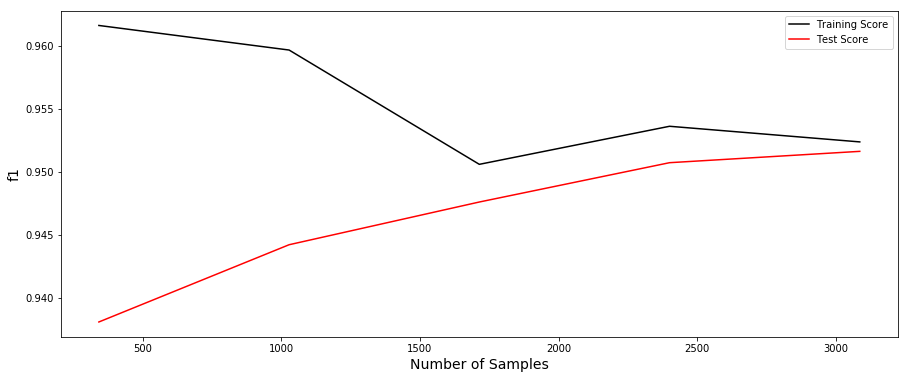

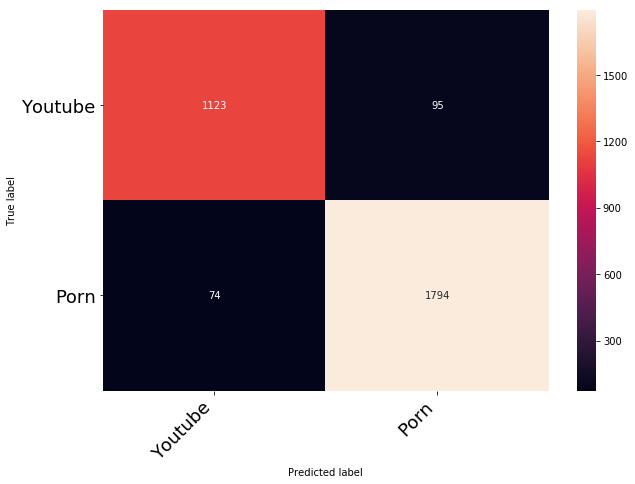

In [104]:
plot_model_nlp(LR, (cv, 'svd', ssX, 10, 'cv+svd'), X_train, y_train, 'f1')

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


0: ['sex', 'gonna', 'think', 'time', 'want', 'oh', 'make', 'good', 'got', 'going']
1: ['sex', 'talk', 'different', 'body', 'sexual', 'idea', 'great', 'vagina', 'uncomfortable', 'place']
2: ['think', 'relationship', 'u', 'oh', 'said', 'open', 'dress', 'super', 'trying', 'started']
3: ['gonna', 'boy', 'think', 'point', 'body', 'way', 'look', 'right', 'say', 'hair']
4: ['make', 'want', 'relationship', 'love', 'boy', 'think', 'friend', 'sure', 'make sure', 'point']
5: ['boy', 'oh', 'look', 'point', 'day', 'body', 'cool', 'school', 'god', 'way']
6: ['good', 'friend', 'oh', 'love', 'want', 'video', 'maybe', 'come', 'different', 'reason']
7: ['oh', 'make', 'sure', 'yes', 'make sure', 'need', 'start', 'little', 'stop', 'god']
8: ['need', 'yes', 'good', 'got', 'say', 'safe', 'person', 'work', 'trying', 'doing']
9: ['way', 'body', 'day', 'want', 'able', 'dress', 'going', 'trying', 'sexual', 'idea']
The cross_val f1 is: 0.96116
The test f1 is: 0.94754


/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


0: ['want', 'sex', 'time', 'think', 'gonna', 'make', 'oh', 'right', 'going', 'video']
1: ['sex', 'work', 'different', 'sex worker', 'worker', 'body', 'period', 'stoma', 'sexual', 'website']
2: ['think', 'oh', 'god', 'time', 'oh god', 'relationship', 'friend', 'sex', 'got', 'best']
3: ['gonna', 'boy', 'time', 'body', 'day', 'oh', 'make', 'oh god', 'god', 'got']
4: ['boy', 'think', 'right', 'way', 'say', 'girl', 'point', 'leg', 'ton', 'wrong']
5: ['gonna', 'right', 'little', 'think', 'little bit', 'bit', 'u', 'going', 'bar', 'loop']
6: ['little', 'relationship', 'bit', 'make', 'little bit', 'ring', 'cock', 'cock ring', 'sure', 'think']
7: ['ring', 'gonna', 'oh', 'boy', 'cock', 'cock ring', 'think', 'talk', 'video', 'want']
8: ['body', 'friend', 'video', 'good', 'able', 'love', 'person', 'let', 'best', 'mean']
9: ['going', 'video', 'good', 'oh', 'day', 'need', 'bit', 'look', 'mean', 'little']
The cross_val f1 is: 0.96732
The test f1 is: 0.96612


/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


0: ['sex', 'want', 'think', 'time', 'gonna', 'oh', 'make', 'right', 'going', 'way']
1: ['sex', 'period', 'sexual', 'period sex', 'vagina', 'sex worker', 'asexual', 'worker', 'work', 'sex work']
2: ['want', 'make', 'right', 'make sure', 'sure', 'boy', 'ring', 'talk', 'trans', 'gonna']
3: ['think', 'want', 'relationship', 'friend', 'love', 'u', 'best', 'life', 'best friend', 'period']
4: ['oh', 'want', 'time', 'god', 'oh god', 'friend', 'love', 'period', 'got', 'life']
5: ['love', 'make', 'body', 'friend', 'trans', 'time', 'person', 'sure', 'relationship', 'year']
6: ['going', 'make', 'little', 'oh', 'ring', 'cock', 'sure', 'let', 'cock ring', 'look']
7: ['boy', 'oh', 'body', 'love', 'look', 'right', 'trans', 'say', 'gonna', 'feminine']
8: ['boy', 'time', 'think', 'ring', 'make', 'sure', 'cock ring', 'cock', 'want', 'kind']
9: ['boy', 'going', 'way', 'got', 'feminine', 'say', 'right', 'point', 'day', 'look']
The cross_val f1 is: 0.96915
The test f1 is: 0.96769


/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


0: ['sex', 'want', 'think', 'time', 'oh', 'make', 'gonna', 'going', 'right', 'way']
1: ['sex', 'sexual', 'period', 'period sex', 'vagina', 'work', 'asexual', 'sex worker', 'different', 'positive']
2: ['oh', 'think', 'god', 'oh god', 'time', 'sex', 'got', 'day', 'look', 'period']
3: ['think', 'relationship', 'friend', 'love', 'talking', 'u', 'best', 'open', 'woman', 'porn']
4: ['want', 'oh', 'god', 'oh god', 'period', 'sex', 'talk', 'period sex', 'life', 'friend']
5: ['gonna', 'right', 'got', 'day', 'sex', 'music', 'today', 'chicken', 'think', 'excited']
6: ['time', 'think', 'friend', 'want', 'year', 'say', 'relationship', 'person', 'best', 'love']
7: ['make', 'body', 'oh', 'boy', 'love', 'trans', 'right', 'look', 'say', 'gonna']
8: ['love', 'friend', 'got', 'video', 'little', 'gonna', 'trans', 'day', 'year', 'best']
9: ['little', 'make', 'think', 'bit', 'video', 'little bit', 'ring', 'sure', 'make sure', 'time']
The cross_val f1 is: 0.97172
The test f1 is: 0.97138


/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


0: ['sex', 'want', 'think', 'time', 'oh', 'gonna', 'make', 'going', 'right', 'way']
1: ['sex', 'sexual', 'having', 'period', 'having sex', 'work', 'shame', 'period sex', 'asexual', 'sex work']
2: ['oh', 'think', 'god', 'oh god', 'sex', 'time', 'look', 'day', 'got', 'thank']
3: ['think', 'relationship', 'friend', 'u', 'way', 'year', 'love', 'kind', 'better', 'talking']
4: ['want', 'oh', 'god', 'oh god', 'sex', 'think', 'period', 'video', 'going', 'talk']
5: ['time', 'want', 'think', 'gonna', 'period', 'relationship', 'long', 'life', 'doing', 'friend']
6: ['gonna', 'going', 'right', 'got', 'little', 'today', 'music', 'sex', 'let', 'look']
7: ['gonna', 'make', 'body', 'boy', 'love', 'oh', 'right', 'say', 'trans', 'work']
8: ['love', 'friend', 'got', 'video', 'little', 'trans', 'life', 'say', 'day', 'gonna']
9: ['little', 'bit', 'think', 'little bit', 'ring', 'make', 'video', 'cock', 'cock ring', 'sure']
The cross_val f1 is: 0.96968
The test f1 is: 0.98822


(0.96968, 0.98822)

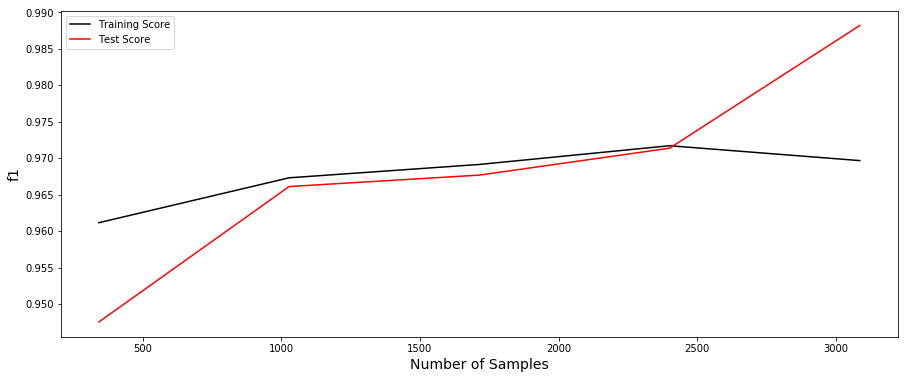

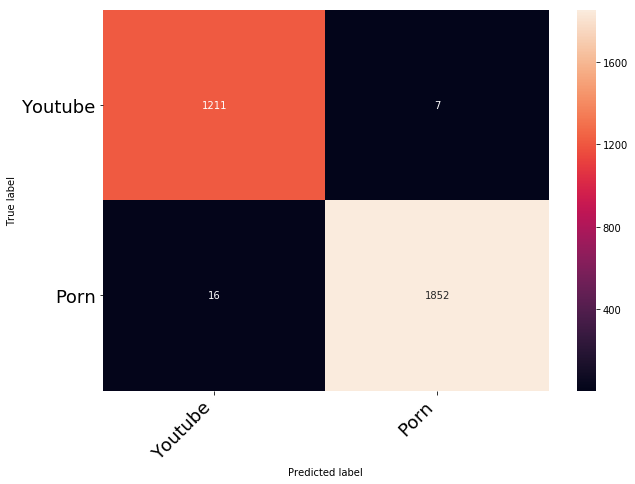

In [107]:
plot_model_nlp(GBC, (cv, 'svd', ssX, 10, 'cv+svd'), X_train, y_train, 'f1')

In [105]:
sorted([(col, coef) for col, coef in zip(column_names, GBC.feature_importances_)], key = lambda x: abs(x[1]), reverse = True)

[('Topic 0', 0.26296456762533293),
 ('spec_var', 0.13133638387248797),
 ('rmse_median', 0.10423593583923335),
 ('Topic 6', 0.0648486846958454),
 ('spec_median', 0.06092652950663181),
 ('Topic 4', 0.0559766795317285),
 ('zero_var', 0.05067527160305597),
 ('Topic 7', 0.05028187153863871),
 ('per_video', 0.04982882390818702),
 ('zero_median', 0.04378197743214631),
 ('rmse_var', 0.027733589701226156),
 ('Topic 9', 0.027204525767266556),
 ('Topic 5', 0.017110219641494333),
 ('Topic 8', 0.01635925711304571),
 ('Topic 1', 0.015752692960917344),
 ('Topic 3', 0.011289094307055008),
 ('Topic 2', 0.009693894955706883)]

In [114]:
GBC = GradientBoostingClassifier(random_state = 42)
gbc_params = {
    'learning_rate': [0.001, 0.01, 0.1, 0.5],
    'n_estimators': [10, 100, 1000, 10000],
    'min_samples_split': [2, 5, 7],
    'min_samples_leaf': [1, 2],
    'max_depth': [2, 3, 4, 5]
}

grid = GridSearchCV(GBC, param_grid=gbc_params, scoring = 'f1', cv = 5)

In [116]:
grid.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'learning_rate': [0.001, 0.01, 0.1, 0.5], 'n_estimators': [10, 100, 1000, 10000], 'min_samples_split': [2, 5, 7], 'min_samples_leaf': [1, 2], 'max_depth': [2, 3, 4, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [117]:
grid.best_params_

{'learning_rate': 0.1,
 'max_depth': 4,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 1000}

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


0: ['sex', 'gonna', 'think', 'time', 'want', 'oh', 'make', 'good', 'got', 'going']
1: ['sex', 'talk', 'different', 'body', 'sexual', 'idea', 'great', 'vagina', 'uncomfortable', 'place']
2: ['think', 'relationship', 'u', 'oh', 'said', 'open', 'dress', 'super', 'trying', 'started']
3: ['gonna', 'boy', 'think', 'point', 'body', 'way', 'look', 'right', 'say', 'hair']
4: ['make', 'want', 'relationship', 'love', 'boy', 'think', 'friend', 'sure', 'make sure', 'point']
5: ['boy', 'oh', 'look', 'point', 'day', 'body', 'cool', 'school', 'god', 'way']
6: ['good', 'friend', 'oh', 'love', 'want', 'video', 'maybe', 'come', 'different', 'reason']
7: ['oh', 'make', 'sure', 'yes', 'make sure', 'need', 'start', 'little', 'stop', 'god']
8: ['need', 'yes', 'good', 'got', 'say', 'safe', 'person', 'work', 'trying', 'doing']
9: ['way', 'body', 'day', 'want', 'able', 'dress', 'going', 'trying', 'sexual', 'idea']
The cross_val f1 is: 0.96126
The test f1 is: 0.94945


/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


0: ['want', 'sex', 'time', 'think', 'gonna', 'make', 'oh', 'right', 'going', 'video']
1: ['sex', 'work', 'different', 'sex worker', 'worker', 'body', 'period', 'stoma', 'sexual', 'website']
2: ['think', 'oh', 'god', 'time', 'oh god', 'relationship', 'friend', 'sex', 'got', 'best']
3: ['gonna', 'boy', 'time', 'body', 'day', 'oh', 'make', 'oh god', 'god', 'got']
4: ['boy', 'think', 'right', 'way', 'say', 'girl', 'point', 'leg', 'ton', 'wrong']
5: ['gonna', 'right', 'little', 'think', 'little bit', 'bit', 'u', 'going', 'bar', 'loop']
6: ['little', 'relationship', 'bit', 'make', 'little bit', 'ring', 'cock', 'cock ring', 'sure', 'think']
7: ['ring', 'gonna', 'oh', 'boy', 'cock', 'cock ring', 'think', 'talk', 'video', 'want']
8: ['body', 'friend', 'video', 'good', 'able', 'love', 'person', 'let', 'best', 'mean']
9: ['going', 'video', 'good', 'oh', 'day', 'need', 'bit', 'look', 'mean', 'little']
The cross_val f1 is: 0.9683
The test f1 is: 0.96612


/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


0: ['sex', 'want', 'think', 'time', 'gonna', 'oh', 'make', 'right', 'going', 'way']
1: ['sex', 'period', 'sexual', 'period sex', 'vagina', 'sex worker', 'asexual', 'worker', 'work', 'sex work']
2: ['want', 'make', 'right', 'make sure', 'sure', 'boy', 'ring', 'talk', 'trans', 'gonna']
3: ['think', 'want', 'relationship', 'friend', 'love', 'u', 'best', 'life', 'best friend', 'period']
4: ['oh', 'want', 'time', 'god', 'oh god', 'friend', 'love', 'period', 'got', 'life']
5: ['love', 'make', 'body', 'friend', 'trans', 'time', 'person', 'sure', 'relationship', 'year']
6: ['going', 'make', 'little', 'oh', 'ring', 'cock', 'sure', 'let', 'cock ring', 'look']
7: ['boy', 'oh', 'body', 'love', 'look', 'right', 'trans', 'say', 'gonna', 'feminine']
8: ['boy', 'time', 'think', 'ring', 'make', 'sure', 'cock ring', 'cock', 'want', 'kind']
9: ['boy', 'going', 'way', 'got', 'feminine', 'say', 'right', 'point', 'day', 'look']
The cross_val f1 is: 0.97164
The test f1 is: 0.97165


/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


0: ['sex', 'want', 'think', 'time', 'oh', 'make', 'gonna', 'going', 'right', 'way']
1: ['sex', 'sexual', 'period', 'period sex', 'vagina', 'work', 'asexual', 'sex worker', 'different', 'positive']
2: ['oh', 'think', 'god', 'oh god', 'time', 'sex', 'got', 'day', 'look', 'period']
3: ['think', 'relationship', 'friend', 'love', 'talking', 'u', 'best', 'open', 'woman', 'porn']
4: ['want', 'oh', 'god', 'oh god', 'period', 'sex', 'talk', 'period sex', 'life', 'friend']
5: ['gonna', 'right', 'got', 'day', 'sex', 'music', 'today', 'chicken', 'think', 'excited']
6: ['time', 'think', 'friend', 'want', 'year', 'say', 'relationship', 'person', 'best', 'love']
7: ['make', 'body', 'oh', 'boy', 'love', 'trans', 'right', 'look', 'say', 'gonna']
8: ['love', 'friend', 'got', 'video', 'little', 'gonna', 'trans', 'day', 'year', 'best']
9: ['little', 'make', 'think', 'bit', 'video', 'little bit', 'ring', 'sure', 'make sure', 'time']
The cross_val f1 is: 0.97274
The test f1 is: 0.97634


/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


0: ['sex', 'want', 'think', 'time', 'oh', 'gonna', 'make', 'going', 'right', 'way']
1: ['sex', 'sexual', 'having', 'period', 'having sex', 'work', 'shame', 'period sex', 'asexual', 'sex work']
2: ['oh', 'think', 'god', 'oh god', 'sex', 'time', 'look', 'day', 'got', 'thank']
3: ['think', 'relationship', 'friend', 'u', 'way', 'year', 'love', 'kind', 'better', 'talking']
4: ['want', 'oh', 'god', 'oh god', 'sex', 'think', 'period', 'video', 'going', 'talk']
5: ['time', 'want', 'think', 'gonna', 'period', 'relationship', 'long', 'life', 'doing', 'friend']
6: ['gonna', 'going', 'right', 'got', 'little', 'today', 'music', 'sex', 'let', 'look']
7: ['gonna', 'make', 'body', 'boy', 'love', 'oh', 'right', 'say', 'trans', 'work']
8: ['love', 'friend', 'got', 'video', 'little', 'trans', 'life', 'say', 'day', 'gonna']
9: ['little', 'bit', 'think', 'little bit', 'ring', 'make', 'video', 'cock', 'cock ring', 'sure']
The cross_val f1 is: 0.97155
The test f1 is: 0.99375


(0.97155, 0.99375)

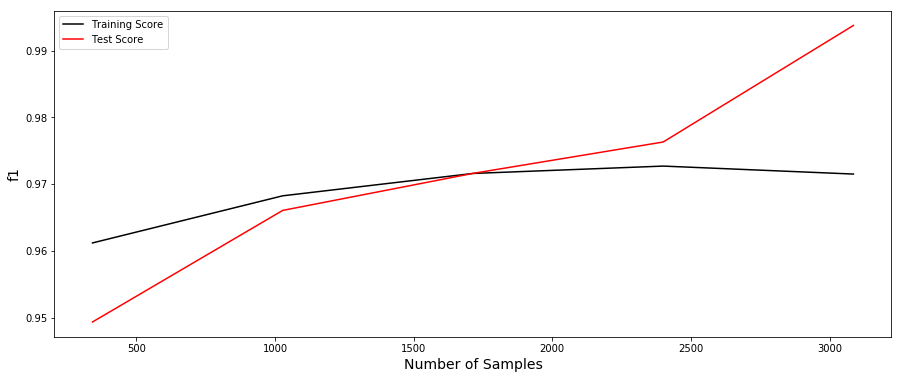

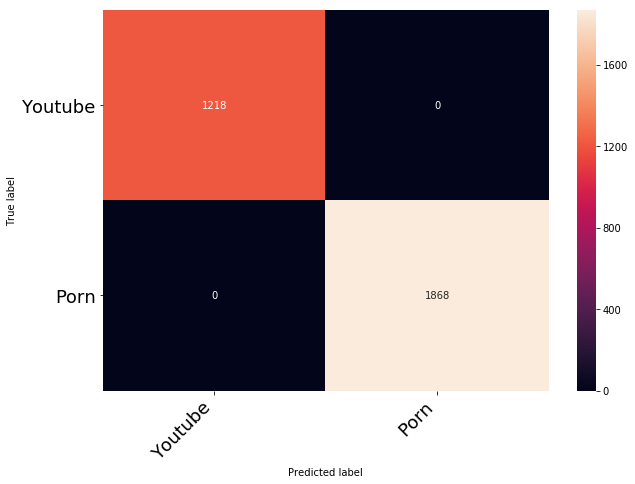

In [120]:
GBC = GradientBoostingClassifier(learning_rate = 0.1, max_depth = 4,
                                 min_samples_split = 5, n_estimators = 1000,
                                 random_state = 42)
plot_model_nlp(GBC, (cv, 'svd', ssX, 10, 'cv+svd'), X_train, y_train, 'f1')

In [119]:
grid.best_score_

0.9757891382987857

In [144]:
n_estimators = [500, 1000, 3000, 5000]
scores = []
for n_est in n_estimators:
    XGB = XGBClassifier(max_depth = 4, learning_rate = 0.1, n_estimators = n_est, random_state = 42)
    folds = KFold(n = len(X_train_scaled), shuffle = True, n_folds = 5, random_state = 42)
    i_f1 = []
    for train_index, test_index in folds:
        Xtrain, Xtest = X_train_scaled[train_index], X_train_scaled[test_index]
        ytrain, ytest = y_train.iloc[train_index], y_train.iloc[test_index]
        XGB.fit(Xtrain, ytrain)
        ypredict = XGB.predict(Xtest)
        i_f1.append(f1_score(ytest, ypredict))
    scores.append((n_est, np.round(np.mean(i_f1), 5)))

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

In [145]:
scores

[(500, 0.97565), (1000, 0.97613), (3000, 0.97547), (5000, 0.97499)]

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


0: ['sex', 'gonna', 'think', 'time', 'want', 'oh', 'make', 'good', 'got', 'going']
1: ['sex', 'talk', 'different', 'body', 'sexual', 'idea', 'great', 'vagina', 'uncomfortable', 'place']
2: ['think', 'relationship', 'u', 'oh', 'said', 'open', 'dress', 'super', 'trying', 'started']
3: ['gonna', 'boy', 'think', 'point', 'body', 'way', 'look', 'right', 'say', 'hair']
4: ['make', 'want', 'relationship', 'love', 'boy', 'think', 'friend', 'sure', 'make sure', 'point']
5: ['boy', 'oh', 'look', 'point', 'day', 'body', 'cool', 'school', 'god', 'way']
6: ['good', 'friend', 'oh', 'love', 'want', 'video', 'maybe', 'come', 'different', 'reason']
7: ['oh', 'make', 'sure', 'yes', 'make sure', 'need', 'start', 'little', 'stop', 'god']
8: ['need', 'yes', 'good', 'got', 'say', 'safe', 'person', 'work', 'trying', 'doing']
9: ['way', 'body', 'day', 'want', 'able', 'dress', 'going', 'trying', 'sexual', 'idea']


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

The cross_val f1 is: 0.97092


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


The test f1 is: 0.95004
0: ['want', 'sex', 'time', 'think', 'gonna', 'make', 'oh', 'right', 'going', 'video']
1: ['sex', 'work', 'different', 'sex worker', 'worker', 'body', 'period', 'stoma', 'sexual', 'website']
2: ['think', 'oh', 'god', 'time', 'oh god', 'relationship', 'friend', 'sex', 'got', 'best']
3: ['gonna', 'boy', 'time', 'body', 'day', 'oh', 'make', 'oh god', 'god', 'got']
4: ['boy', 'think', 'right', 'way', 'say', 'girl', 'point', 'leg', 'ton', 'wrong']
5: ['gonna', 'right', 'little', 'think', 'little bit', 'bit', 'u', 'going', 'bar', 'loop']
6: ['little', 'relationship', 'bit', 'make', 'little bit', 'ring', 'cock', 'cock ring', 'sure', 'think']
7: ['ring', 'gonna', 'oh', 'boy', 'cock', 'cock ring', 'think', 'talk', 'video', 'want']
8: ['body', 'friend', 'video', 'good', 'able', 'love', 'person', 'let', 'best', 'mean']
9: ['going', 'video', 'good', 'oh', 'day', 'need', 'bit', 'look', 'mean', 'little']


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

The cross_val f1 is: 0.97058


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


The test f1 is: 0.96698
0: ['sex', 'want', 'think', 'time', 'gonna', 'oh', 'make', 'right', 'going', 'way']
1: ['sex', 'period', 'sexual', 'period sex', 'vagina', 'sex worker', 'asexual', 'worker', 'work', 'sex work']
2: ['want', 'make', 'right', 'make sure', 'sure', 'boy', 'ring', 'talk', 'trans', 'gonna']
3: ['think', 'want', 'relationship', 'friend', 'love', 'u', 'best', 'life', 'best friend', 'period']
4: ['oh', 'want', 'time', 'god', 'oh god', 'friend', 'love', 'period', 'got', 'life']
5: ['love', 'make', 'body', 'friend', 'trans', 'time', 'person', 'sure', 'relationship', 'year']
6: ['going', 'make', 'little', 'oh', 'ring', 'cock', 'sure', 'let', 'cock ring', 'look']
7: ['boy', 'oh', 'body', 'love', 'look', 'right', 'trans', 'say', 'gonna', 'feminine']
8: ['boy', 'time', 'think', 'ring', 'make', 'sure', 'cock ring', 'cock', 'want', 'kind']
9: ['boy', 'going', 'way', 'got', 'feminine', 'say', 'right', 'point', 'day', 'look']


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

The cross_val f1 is: 0.97322


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


The test f1 is: 0.96606
0: ['sex', 'want', 'think', 'time', 'oh', 'make', 'gonna', 'going', 'right', 'way']
1: ['sex', 'sexual', 'period', 'period sex', 'vagina', 'work', 'asexual', 'sex worker', 'different', 'positive']
2: ['oh', 'think', 'god', 'oh god', 'time', 'sex', 'got', 'day', 'look', 'period']
3: ['think', 'relationship', 'friend', 'love', 'talking', 'u', 'best', 'open', 'woman', 'porn']
4: ['want', 'oh', 'god', 'oh god', 'period', 'sex', 'talk', 'period sex', 'life', 'friend']
5: ['gonna', 'right', 'got', 'day', 'sex', 'music', 'today', 'chicken', 'think', 'excited']
6: ['time', 'think', 'friend', 'want', 'year', 'say', 'relationship', 'person', 'best', 'love']
7: ['make', 'body', 'oh', 'boy', 'love', 'trans', 'right', 'look', 'say', 'gonna']
8: ['love', 'friend', 'got', 'video', 'little', 'gonna', 'trans', 'day', 'year', 'best']
9: ['little', 'make', 'think', 'bit', 'video', 'little bit', 'ring', 'sure', 'make sure', 'time']


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

The cross_val f1 is: 0.97547


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


The test f1 is: 0.97314
0: ['sex', 'want', 'think', 'time', 'oh', 'gonna', 'make', 'going', 'right', 'way']
1: ['sex', 'sexual', 'having', 'period', 'having sex', 'work', 'shame', 'period sex', 'asexual', 'sex work']
2: ['oh', 'think', 'god', 'oh god', 'sex', 'time', 'look', 'day', 'got', 'thank']
3: ['think', 'relationship', 'friend', 'u', 'way', 'year', 'love', 'kind', 'better', 'talking']
4: ['want', 'oh', 'god', 'oh god', 'sex', 'think', 'period', 'video', 'going', 'talk']
5: ['time', 'want', 'think', 'gonna', 'period', 'relationship', 'long', 'life', 'doing', 'friend']
6: ['gonna', 'going', 'right', 'got', 'little', 'today', 'music', 'sex', 'let', 'look']
7: ['gonna', 'make', 'body', 'boy', 'love', 'oh', 'right', 'say', 'trans', 'work']
8: ['love', 'friend', 'got', 'video', 'little', 'trans', 'life', 'say', 'day', 'gonna']
9: ['little', 'bit', 'think', 'little bit', 'ring', 'make', 'video', 'cock', 'cock ring', 'sure']


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

The cross_val f1 is: 0.97292
The test f1 is: 0.99218


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


(0.97292, 0.99218)

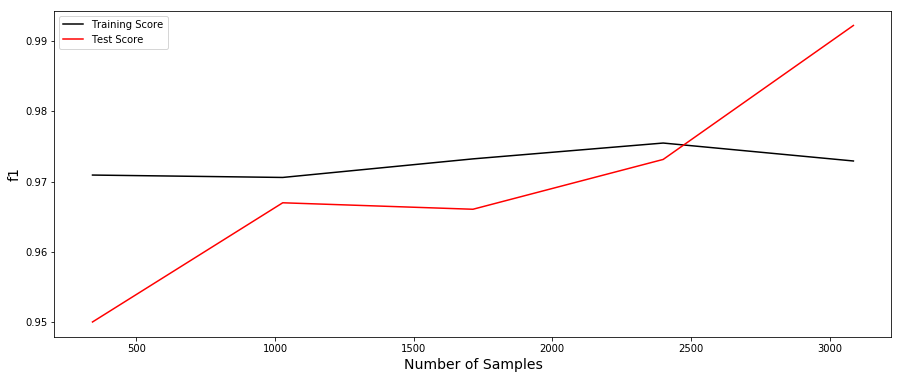

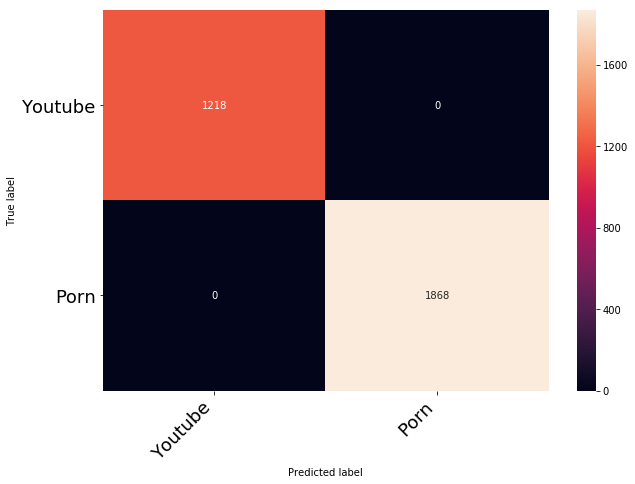

In [147]:
XGB = XGBClassifier(max_depth = 4, learning_rate = 0.1, n_estimators = 1000, random_state = 42)
plot_model_nlp(XGB, (cv, 'svd', ssX, 10, 'cv+svd'), X_train, y_train, 'f1')

In [148]:
sorted([(col, coef) for col, coef in zip(column_names, XGB.feature_importances_)], key = lambda x: abs(x[1]), reverse = True)

[('rmse_median', 0.10948905),
 ('Topic 0', 0.1),
 ('spec_var', 0.096532844),
 ('spec_median', 0.08430657),
 ('rmse_var', 0.0729927),
 ('per_video', 0.06788321),
 ('zero_median', 0.06368613),
 ('zero_var', 0.06295621),
 ('Topic 6', 0.055839416),
 ('Topic 7', 0.054927006),
 ('Topic 3', 0.039233577),
 ('Topic 2', 0.037043795),
 ('Topic 1', 0.03631387),
 ('Topic 9', 0.035036497),
 ('Topic 4', 0.034124088),
 ('Topic 5', 0.029014599),
 ('Topic 8', 0.020620437)]

### Dummy Classifer

In [176]:
DC = DummyClassifier(strategy = 'stratified')
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size = 0.3, random_state = 42, stratify = y)
X_train_scaled = pd.concat((X_train.iloc[:, 0], X_train.iloc[:, 2:]), axis = 1)
train_accuracy_score = np.round(np.mean(
    cross_val_score(DC, X_train_scaled, y_train, scoring = 'accuracy', cv = 10)), 5)
print(f"Model's accuracy score: {train_accuracy_score}")
train_f1_score = np.round(np.mean(
    cross_val_score(DC, X_train_scaled, y_train, scoring = 'f1', cv = 10)), 5)
print(f"Model's f1 score: {train_f1_score}")

Model's accuracy score: 0.513
Model's f1 score: 0.60996


### Audio only XBG

In [173]:
ssX = StandardScaler()
XGB = XGBClassifier(max_depth = 4, learning_rate = 0.1, n_estimators = 1000, random_state = 42)
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size = 0.3, random_state = 42, stratify = y)  
X_train_scaled = ssX.fit_transform(pd.concat((X_train.iloc[:, 0], X_train.iloc[:, 2:]), axis = 1))
train_accuracy_score = np.round(np.mean(
    cross_val_score(XGB, X_train_scaled, y_train, scoring = 'accuracy', cv = 10)), 5)
print(f"Model's accuracy score: {train_accuracy_score}")
train_f1_score = np.round(np.mean(
    cross_val_score(XGB, X_train_scaled, y_train, scoring = 'f1', cv = 10)), 5)
print(f"Model's f1 score: {train_f1_score}")

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

Model's accuracy score: 0.94752


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

Model's f1 score: 0.95653


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


### Audio + NLP XBG

In [174]:
ssX = StandardScaler()
XGB = XGBClassifier(max_depth = 4, learning_rate = 0.1, n_estimators = 1000, random_state = 42)
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size = 0.3, random_state = 42, stratify = y)    
X_train_scaled, column_names, ssX, vectorizer, reducer = scale_nlp_xtrain(X_train, cv, 'svd', ssX, 10)
train_accuracy_score = np.round(np.mean(
    cross_val_score(XGB, X_train_scaled, y_train, scoring = 'accuracy', cv = 10)), 5)
print(f"Model's accuracy score: {train_accuracy_score}")
train_f1_score = np.round(np.mean(
    cross_val_score(XGB, X_train_scaled, y_train, scoring = 'f1', cv = 10)), 5)
print(f"Model's f1 score: {train_f1_score}")

0: ['want', 'sex', 'think', 'time', 'oh', 'make', 'gonna', 'going', 'right', 'good']
1: ['sex', 'sexual', 'having', 'period', 'having sex', 'work', 'shame', 'period sex', 'asexual', 'positive']
2: ['want', 'make', 'video', 'going', 'gonna', 'right', 'need', 'make sure', 'sure', 'way']
3: ['think', 'relationship', 'way', 'year', 'friend', 'love', 'kind', 'u', 'person', 'mean']
4: ['want', 'think', 'oh', 'god', 'oh god', 'sex', 'video', 'period', 'talk', 'think want']
5: ['time', 'want', 'think', 'friend', 'long', 'relationship', 'period', 'life', 'day', 'year']
6: ['love', 'make', 'trans', 'friend', 'body', 'say', 'boy', 'ha', 'person', 'video']
7: ['gonna', 'right', 'boy', 'body', 'say', 'look', 'day', 'video', 'music', 'hair']
8: ['little', 'video', 'got', 'bit', 'little bit', 'love', 'friend', 'life', 'talk', 'need']
9: ['make', 'little', 'ring', 'think', 'cock', 'cock ring', 'sure', 'bit', 'make sure', 'video']


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

Model's accuracy score: 0.97347


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

Model's f1 score: 0.97798


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


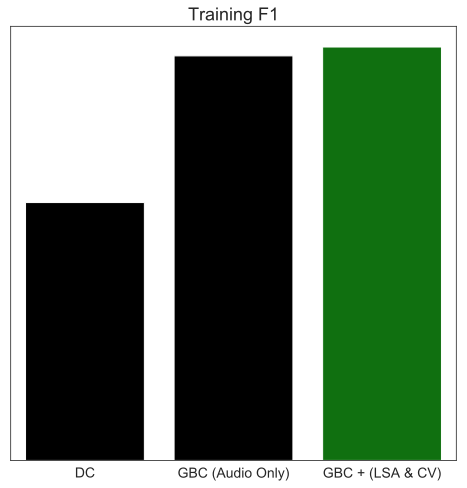

In [202]:
plt.rcParams.update({'figure.figsize': (8,8)})
fig, ax = plt.subplots(1)
x_bar = ['DC', 'GBC (Audio Only)', 'GBC + (LSA & CV)']
y_bar = [0.610, 0.957, 0.978]
color_bar = ['k','k','g']
sns.barplot(x_bar, y_bar, palette=color_bar, ax = ax)
plt.xticks(fontsize=14)
plt.title('Training F1', fontsize = 18)
ax.set_yticklabels([]);

### Final Model Performance

In [6]:
ssX = StandardScaler()
with open('video_df.pkl', 'rb') as filename:
    df = pickle.load(filename)
    filename.close()
X = df.iloc[:, 1:-1]
y = df.iloc[:, -1]
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size = 0.3, random_state = 42, stratify = y)    
X_train_scaled, column_names, ssX, vectorizer, reducer = scale_nlp_xtrain(X_train, cv, 'svd', ssX, 10)
X_test_scaled = transform_testdata(X_test, vectorizer, reducer, ssX)    

XGB = XGBClassifier(max_depth = 4, learning_rate = 0.1, n_estimators = 1000, random_state = 42)
XGB.fit(X_train_scaled, y_train)
y_predict = XGB.predict(X_test_scaled)

0: ['want', 'sex', 'think', 'time', 'oh', 'make', 'gonna', 'going', 'right', 'good']
1: ['sex', 'sexual', 'having', 'period', 'having sex', 'work', 'shame', 'period sex', 'asexual', 'positive']
2: ['want', 'make', 'video', 'going', 'gonna', 'right', 'need', 'make sure', 'sure', 'way']
3: ['think', 'relationship', 'way', 'year', 'friend', 'love', 'kind', 'u', 'person', 'mean']
4: ['want', 'think', 'oh', 'god', 'oh god', 'sex', 'video', 'period', 'talk', 'think want']
5: ['time', 'want', 'think', 'friend', 'long', 'relationship', 'period', 'life', 'day', 'year']
6: ['love', 'make', 'trans', 'friend', 'body', 'say', 'boy', 'ha', 'person', 'video']
7: ['gonna', 'right', 'boy', 'body', 'say', 'look', 'day', 'video', 'music', 'hair']
8: ['little', 'video', 'got', 'bit', 'little bit', 'love', 'friend', 'life', 'talk', 'need']
9: ['make', 'little', 'ring', 'think', 'cock', 'cock ring', 'sure', 'bit', 'make sure', 'video']


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [9]:
with open('Flask/model/vectorizer.pkl', 'wb') as filename:
    pickle.dump(vectorizer, filename)
    filename.close()
with open('Flask/model/reducer.pkl', 'wb') as filename:
    pickle.dump(reducer, filename)
    filename.close()
with open('Flask/model/standard_scaler.pkl', 'wb') as filename:
    pickle.dump(ssX, filename)
    filename.close()
with open('Flask/model/model.pkl', 'wb') as filename:
    pickle.dump(XGB, filename)
    filename.close()

In [11]:
vectorizer

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.7, max_features=None, min_df=5,
        ngram_range=(1, 2), preprocessor=None,
        stop_words=frozenset({'below', 'whose', 'her', 'moreover', 'across', 'whereby', 'among', 'his', 'whence', 'nobody', 'eg', 'top', 'twenty', 'thus', 'enough', 'latter', 'beyond', 'even', 'go', 'at', 'nine', 'an', 'elsewhere', 'have', 'herein', 'not', 'co', 'which', 'twelve', 'bottom', 'perhaps', 'ie',...f', 'anywhere', 'itself', 'part', 'thereupon', 'amongst', 'cry', 'sixty', 'during', 'none', 'down'}),
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=<nlp_processing.LemmaTokenizer object at 0x1a2709e5c0>,
        vocabulary=None)

In [159]:
final_f1_score = np.round(f1_score(y_test, y_predict), 5)
print(f"Model's f1 score: {final_f1_score}")

Model's f1 score: 0.9781


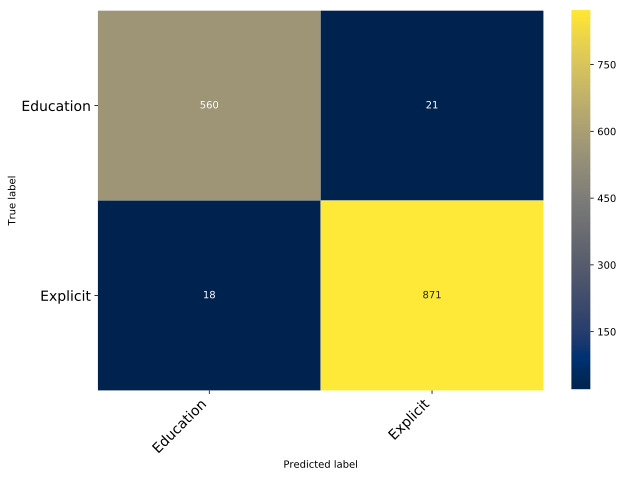

In [15]:
conf_mat = confusion_matrix(y_test, y_predict)
cm = print_confusion_matrix(conf_mat, ['Education', 'Explicit'])